## Run a Custom Trading Algorithm Backtest with Minute Timeseries Pricing Data

This Jupyter notebook uses the [Stock Analysis Engine](https://github.com/AlgoTraders/stock-analysis-engine) to build, run and tune intraday minute-by-minute trading algorithms.

This notebook is a how-to guide for:
    
1. Building an algorithm config dictionary
1. Adding multiple custom [Williams %R indicators](https://www.investopedia.com/terms/w/williamsr.asp) to the algorithm for evaluating buy and sell decisions
1. Building a derived algorithm from the [analysis_engine.algo.BaseAlgo class](https://github.com/AlgoTraders/stock-analysis-engine/blob/master/analysis_engine/algo.py)
1. Running an algorithm backtest over all the trading datasets cached in the redis server
1. While running, plot the algorithm's **trading history** to show how the algorithm's balance is changing vs the stock's closing price for each minute

### Set up the imports and logger

In [1]:
import datetime
import analysis_engine.consts as ae_consts
import analysis_engine.algo as base_algo
import analysis_engine.run_algo as run_algo
import analysis_engine.plot_trading_history as plot_trading_history
import analysis_engine.build_publish_request as build_publish_request
import spylunking.log.setup_logging as log_utils


log = log_utils.build_colorized_logger(name='btnb')

### Build the Algorithm Config Dictionary

In [2]:
config_dict = {
    'name': 'backtest-with-plot',
    'timeseries': 'minute',
    'trade_horizon': 5,
    'buy_shares': 10,
    'balance': 10000.0,
    'commission': 6.0,
    'ticker': 'SPY',
    'show_balance': True,
    'algo_module_path': None,  # file path to your own algo classes
    'algo_version': 1,
    'buy_rules': {
        'confidence': 75,
        'min_indicators': 3   # if more than 3 indicators say buy - open a buy order
    },
    'sell_rules': {
        'confidence': 75,
        'min_indicators': 3   # if more than 3 indicators say sell - open a sell order
    },
    'indicators': [],  # add your own indicators to this list
    'verbose': False,             # log in the algorithm
    'verbose_processor': False,   # log in the indicator processor
    'verbose_indicators': False,  # log all indicators
    'verbose_trading': False,     # log in the algo trading methods
    'inspect_datasets': False     # log dataset metrics - slow
}

### Add Multiple Custom Williams %R Indicators for Minute-by-Minute Trading

In [3]:
config_dict['indicators'] = [
    {
        'name': 'willr_-70_-30',
        'module_path': '/opt/sa/analysis_engine/mocks/example_indicator_williamsr.py',
        'category': 'technical',
        'type': 'momentum',
        'uses_data': 'minute',
        'high': 0,
        'low': 0,
        'close': 0,
        'open': 0,
        'willr_value': 0,
        'num_points': 80,
        'buy_below': -70,
        'sell_above': -30,
        'is_buy': False,
        'is_sell': False,
        'verbose': False  # log in just this indicator
    },
    {
        'name': 'willr_-80_-20',
        'module_path': '/opt/sa/analysis_engine/mocks/example_indicator_williamsr.py',
        'category': 'technical',
        'type': 'momentum',
        'uses_data': 'minute',
        'high': 0,
        'low': 0,
        'close': 0,
        'open': 0,
        'willr_value': 0,
        'num_points': 30,
        'buy_below': -80,
        'sell_above': -20,
        'is_buy': False,
        'is_sell': False
    },
    {
        'name': 'willr_-90_-10',
        'module_path': '/opt/sa/analysis_engine/mocks/example_indicator_williamsr.py',
        'category': 'technical',
        'type': 'momentum',
        'uses_data': 'minute',
        'high': 0,
        'low': 0,
        'close': 0,
        'open': 0,
        'willr_value': 0,
        'num_points': 60,
        'buy_below': -90,
        'sell_above': -10,
        'is_buy': False,
        'is_sell': False
    },
    {
        'name': 'willr_open_-80_-20',
        'module_path': '/opt/sa/analysis_engine/mocks/example_indicator_williamsr_open.py',
        'category': 'technical',
        'type': 'momentum',
        'uses_data': 'minute',
        'high': 0,
        'low': 0,
        'close': 0,
        'open': 0,
        'willr_open_value': 0,
        'num_points': 80,
        'buy_below': -80,
        'sell_above': -20,
        'is_buy': False,
        'is_sell': False
    }
]

## Build a Derived Algorithm from the BaseAlgo class

Notice how there are no custom buy or sell rules involved in this derived algorithm example below. This is because all algorithms support lists of indicators and the concept of a **min_indicators** counter that is already defined in the **buy_rules** and **sell_rules** config dictionary above. The inherited BaseAlgo class counts how many indicators decided buy or sell to see if more than the **min_indicators** count threshold was hit. If this threshold was passed, then the BaseAlgo class will automatically open the buy or a sell trade for you.

**Why do it this way?**

Algorithms were built out of the need to evaluate trading decisions over many diverse, disparate datasets which is beyond the scope of individual technical/fundamental/social/news indicators (which are just math functions). This approach helps reduce how much code you have to write inside of all your algorithms and for easier trade confirmation before committing actual real money.

In [4]:
class ExampleCustomAlgo(base_algo.BaseAlgo):
    """ExampleCustomAlgo"""

    def process(self, algo_id, ticker, dataset):
        """process

        Run a custom algorithm after all the indicators
        from the ``config_dict`` have been processed and all
        the number crunching is done. This allows the algorithm
        class to focus on the high-level trade execution problems
        like bid-ask spreads and opening the buy/sell trade orders.

        **How does it work?**

        The engine provides a data stream from the latest
        pricing updates stored in redis. Once new data is
        stored in redis, algorithms will be able to use
        each ``dataset`` as a chance to evaluate buy and
        sell decisions. These are your own custom logic
        for trading based off what the indicators find
        and any non-indicator data provided from within
        the ``dataset`` dictionary.
        
        Here is what the ``dataset`` variable
        looks like when your algorithm's ``process``
        method is called (assuming you have redis running
        with actual pricing data too):

        **Dataset Dictionary Structure**

        .. code-block:: python

            {
                'id': dataset_id,
                'date': date,
                'data': {
                    'daily': pd.DataFrame([]),
                    'minute': pd.DataFrame([]),
                    'quote': pd.DataFrame([]),
                    'stats': pd.DataFrame([]),
                    'peers': pd.DataFrame([]),
                    'news1': pd.DataFrame([]),
                    'financials': pd.DataFrame([]),
                    'earnings': pd.DataFrame([]),
                    'dividends': pd.DataFrame([]),
                    'calls': pd.DataFrame([]),
                    'puts': pd.DataFrame([]),
                    'pricing': pd.DataFrame([]),
                    'news': pd.DataFrame([])
                }
            }

        .. tip:: you can also inspect these datasets by setting
            the algorithm's config dictionary key
            ``"inspect_datasets": True``

        :param algo_id: string - algo identifier label for debugging datasets
            during specific dates
        :param ticker: string - ticker
        :param dataset: a dictionary of identifiers (for debugging) and
            multiple pandas ``DataFrame`` objects.
        """
        if self.verbose:
            log.info(
                'process start - {} '
                'balance={} '
                'date={} minute={} close={} '
                'high={} low={} open={} volume={}'
                ''.format(
                    self.name,
                    self.balance,
                    self.backtest_date, self.latest_min,
                    self.latest_close, self.latest_high,
                    self.latest_low, self.latest_open,
                    self.latest_volume))
            # there are many more BaseAlgo member variables already set for you too:
            # https://github.com/AlgoTraders/stock-analysis-engine/blob/master/analysis_engine/algo.py#L2

## Customize the Algorithm's Balance and Ticker

In [5]:
ticker = 'SPY'
balance = 10000.00
commission = 6.0

### Finalize the Algorithm's Config Dictionary

In [6]:
verbose_algo = False
verbose_processor = False
verbose_indicators = False
inspect_datasets = False

config_dict['ticker'] = ticker
config_dict['balance'] = balance
config_dict['commission'] = commission

if verbose_algo:
    config_dict['verbose'] = verbose_algo
if verbose_processor:
    config_dict['verbose_processor'] = verbose_processor
if verbose_indicators:
    config_dict['verbose_indicators'] = verbose_indicators
if inspect_datasets:
    config_dict['inspect_datasets'] = inspect_datasets

### Start the Algorithm Backtest and Show the Algorithm's Balance vs the Closing Stock Price while Running

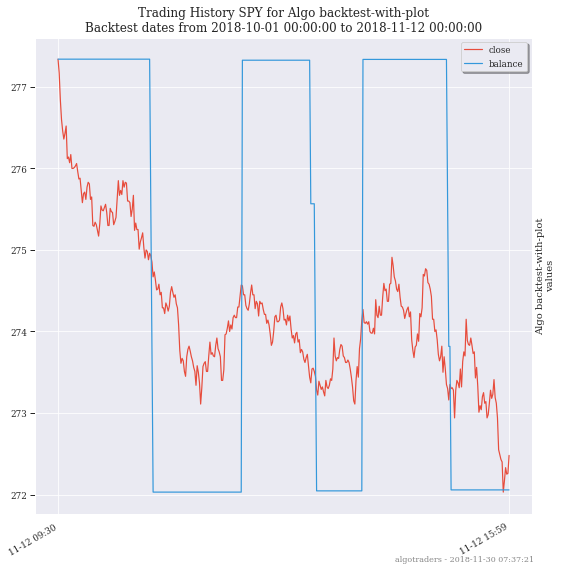

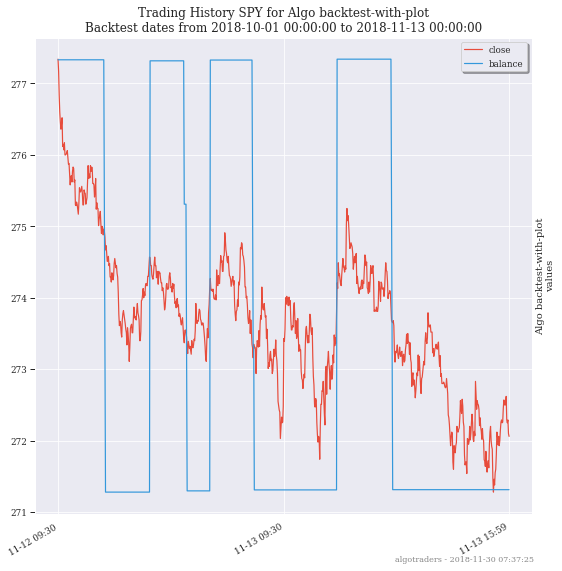

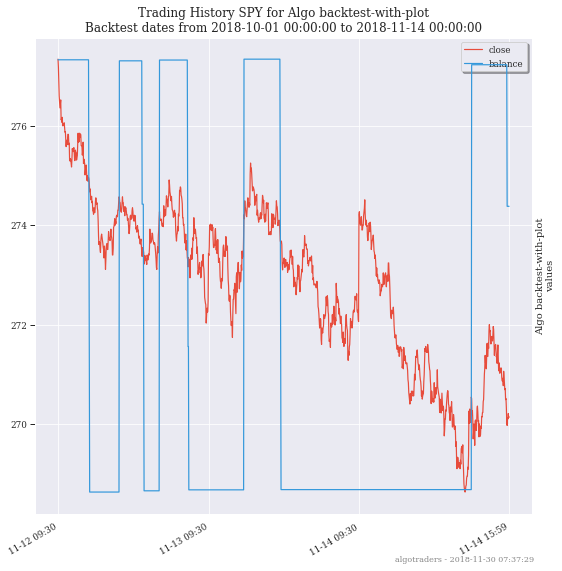

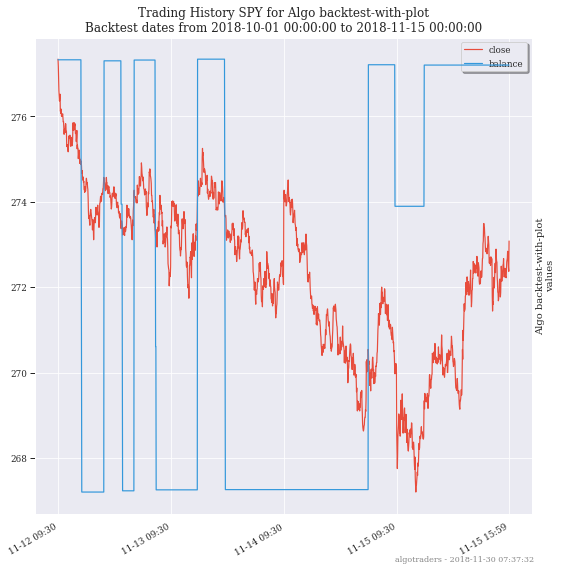

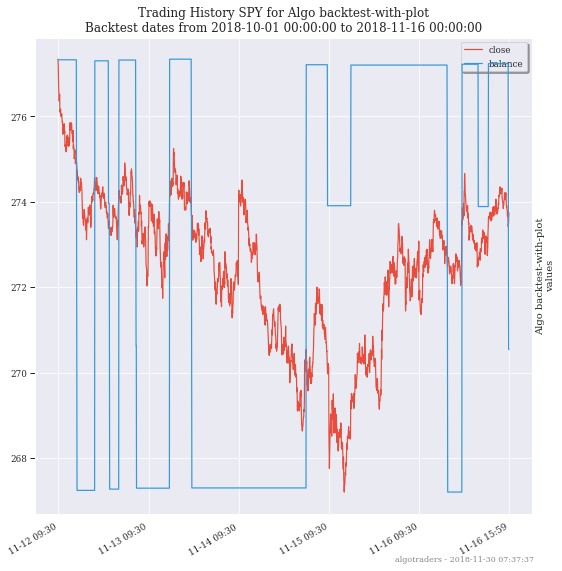

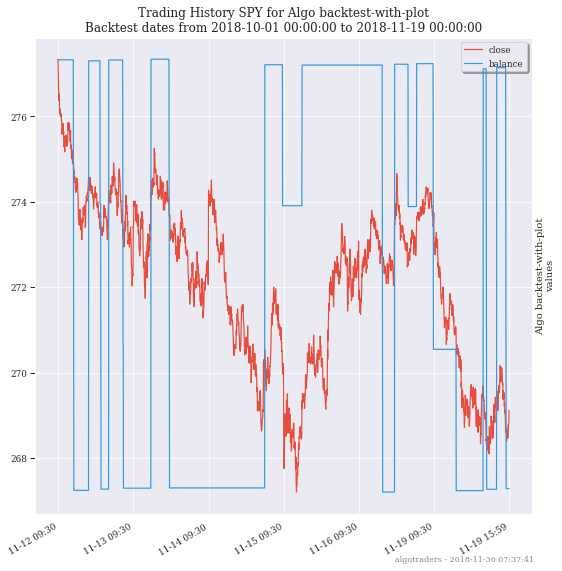

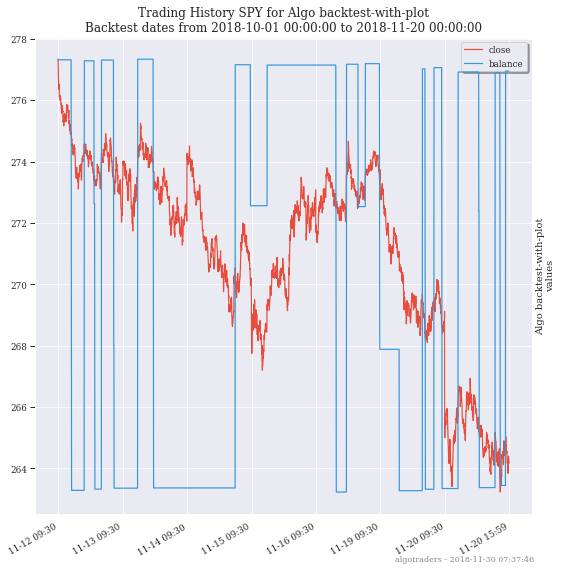

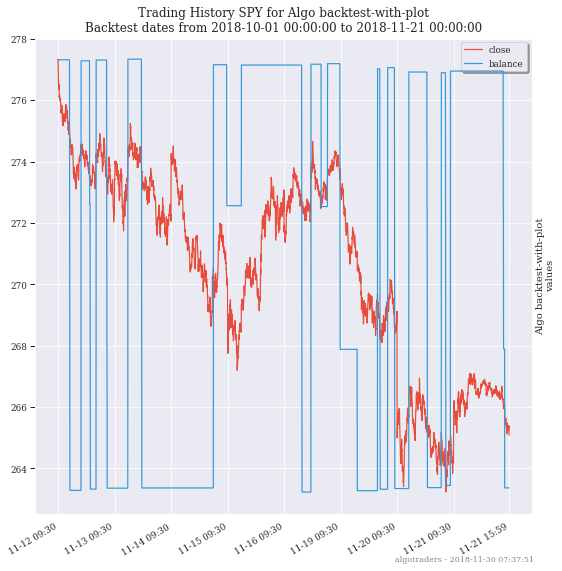

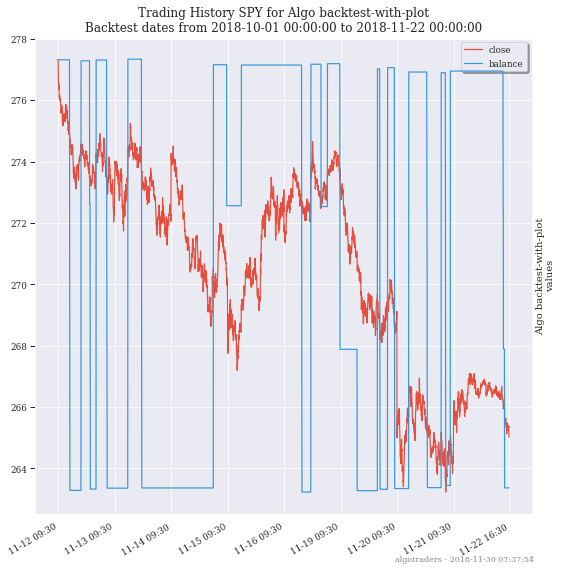

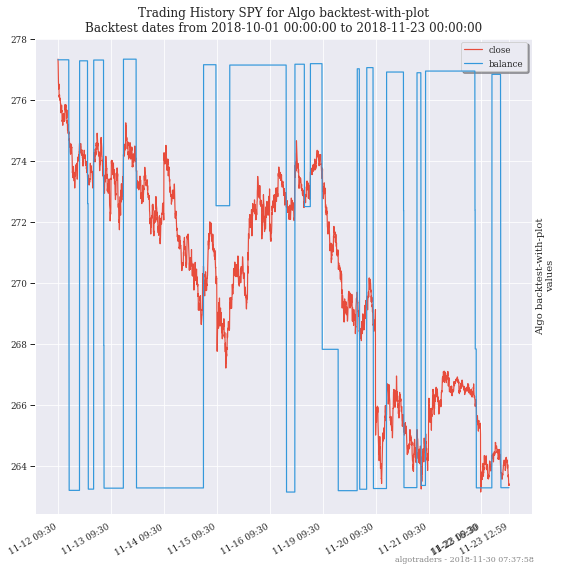

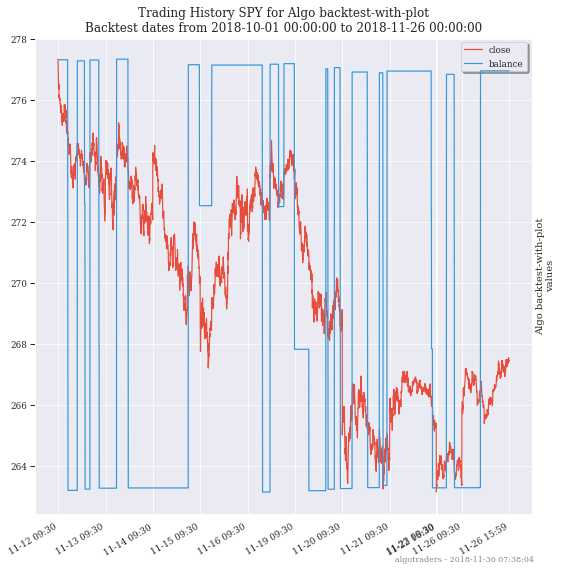

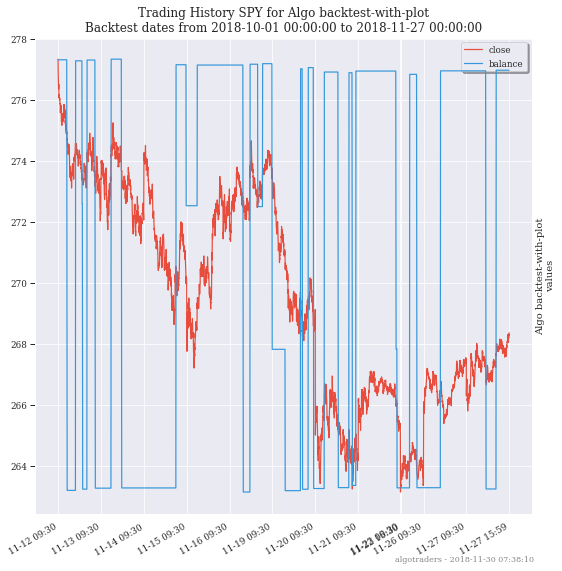

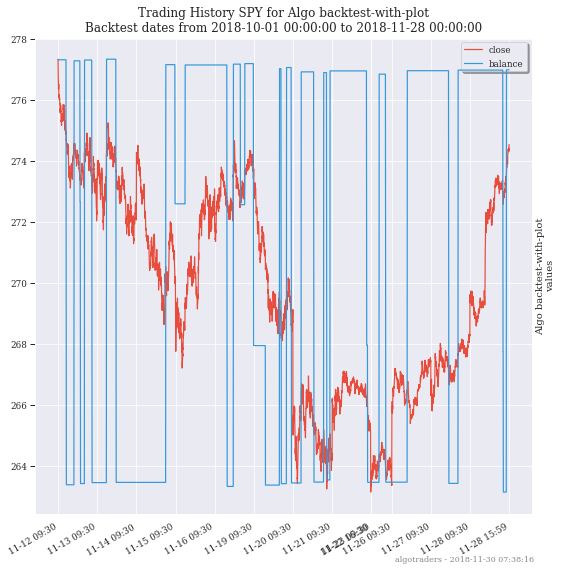

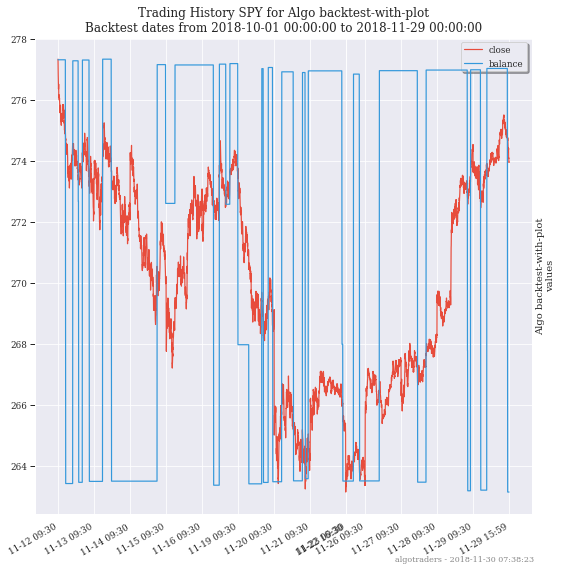

In [7]:
algo_obj = ExampleCustomAlgo(
    ticker=config_dict['ticker'],
    config_dict=config_dict)

algo_res = run_algo.run_algo(
    ticker=ticker,
    algo=algo_obj,
    raise_on_err=True)

if algo_res['status'] != ae_consts.SUCCESS:
    log.error(
        'failed running algo backtest '
        '{} hit status: {} error: {}'.format(
            algo_obj.get_name(),
            ae_consts.get_status(status=algo_res['status']),
            algo_res['err']))

### Plot the Trading History after the Algorithm Finishes the Backtest

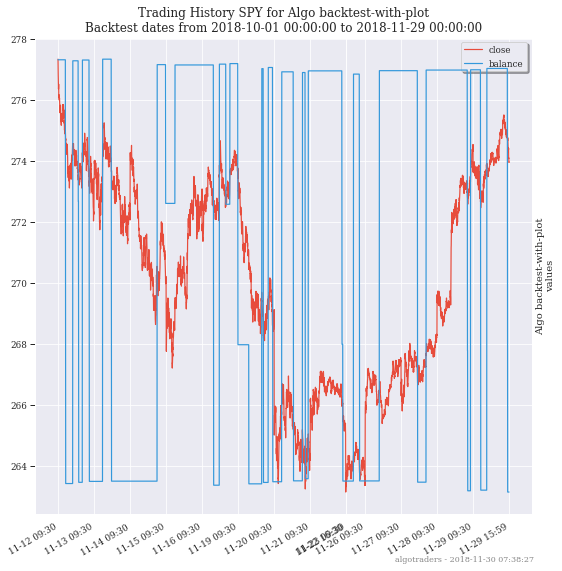

In [8]:
log.info(
    'backtest: {} {}'.format(
        algo_obj.get_name(),
        ae_consts.get_status(status=algo_res['status'])))

trading_history_dict = algo_obj.get_history_dataset()
history_df = trading_history_dict[ticker]

if not hasattr(history_df, 'to_json'):
    log.error(
        'no history to plot')
else:
    debug = False
    history_json_file = None
    if history_json_file:
        log.info(
            'saving history to: {}'.format(
                history_json_file))
        history_df.to_json(
            history_json_file,
            orient='records',
            date_format='iso')

    log.info('plotting history')

    first_date = history_df['date'].iloc[0]
    end_date = history_df['date'].iloc[-1]
    title = (
        'Trading History {} for Algo {}\n'
        'Backtest dates from {} to {}'.format(
            ticker,
            trading_history_dict['algo_name'],
            first_date,
            end_date))
    use_xcol = 'date'
    use_as_date_format = '%d\n%b'
    if config_dict['timeseries'] == 'minute':
        use_xcol = 'minute'
        use_as_date_format = '%d %H:%M:%S\n%b'
    xlabel = 'Dates vs {} values'.format(
        trading_history_dict['algo_name'])
    ylabel = 'Algo {}\nvalues'.format(
        trading_history_dict['algo_name'])
    df_filter = (history_df['close'] > 0.01)

    # There are other columns you can use too!
    # please see the next section:
    red = 'close'
    blue = 'balance'
    green = None
    orange = None

    if debug:
        for i, r in history_df.iterrows():
            print('{} - {}'.format(
                r['minute'],
                r['close']))

    plot_trading_history.plot_trading_history(
        title=title,
        df=history_df,
        red=red,
        blue=blue,
        green=green,
        orange=orange,
        date_col=use_xcol,
        date_format=use_as_date_format,
        xlabel=xlabel,
        ylabel=ylabel,
        df_filter=df_filter,
        show_plot=True,
        dropna_for_all=True)

### What else is in the Algorithm's Trading History?

Some columns are common to all algorithms. The only columns that will change per trading history are likely the custom indicators you add into the algorithm's config dictionary.

Please ensure that each indicator name is unique per algorithm so the indicator values are stored correctly within the trading history. You can have the BaseAlgo class set unique names automatically for you by adding **unique_id=True** into all indicator sections of the algorithm config dictionary, but this is not on-by-default because it is more difficult to automate charting indicator key discovery across many algorithms at once.

In [9]:
print('Here are the available {} columns in this trading history pandas.DataFrame:\n'.format(len(history_df.columns.values)))
print(history_df.columns.values)

Here are the available 128 columns in this trading history pandas.DataFrame:

['algo_price_change' 'algo_start_price' 'algo_status' 'ask' 'balance'
 'balance_net_gain' 'bid' 'breakeven_price' 'buy_hold_units' 'close'
 'commission' 'date' 'ds_id' 'err' 'exp_date' 'high' 'high_ask' 'high_bid'
 'high_delta' 'high_exp_date' 'high_extrinsic' 'high_gamma'
 'high_impl_vol' 'high_intrinsic' 'high_max_covered' 'high_open_int'
 'high_rho' 'high_strike' 'high_theo_price' 'high_theo_volatility'
 'high_theta' 'high_vega' 'high_volume' 'low' 'low_ask' 'low_bid'
 'low_delta' 'low_exp_date' 'low_extrinsic' 'low_gamma' 'low_impl_vol'
 'low_intrinsic' 'low_max_covered' 'low_open_int' 'low_rho' 'low_strike'
 'low_theo_price' 'low_theo_volatility' 'low_theta' 'low_vega'
 'low_volume' 'max_loss' 'max_profit' 'min_buy_indicators'
 'min_sell_indicators' 'minute' 'net_gain' 'note' 'num_indicators'
 'num_indicators_buy' 'num_indicators_sell' 'num_owned' 'open'
 'original_balance' 'prev_balance' 'prev_num_owned

In [10]:
history_df.head(5)

,algo_price_change,algo_start_price,algo_status,ask,balance,balance_net_gain,bid,breakeven_price,buy_hold_units,close,...,willr_open_-80_-20_60_200_501_conf_high,willr_open_-80_-20_60_200_501_conf_is_buy,willr_open_-80_-20_60_200_501_conf_is_sell,willr_open_-80_-20_60_200_501_conf_low,willr_open_-80_-20_60_200_501_conf_num_points,willr_open_-80_-20_60_200_501_conf_obj,willr_open_-80_-20_60_200_501_conf_open,willr_open_-80_-20_60_200_501_conf_sell_above,willr_open_-80_-20_60_200_501_conf_verbose,willr_open_-80_-20_60_200_501_conf_willr_open_value
0,0.0,0.0,35,0.0,10000.0,5000.0,0.0,None,20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,35,0.0,10000.0,5000.0,0.0,None,20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,35,0.0,10000.0,5000.0,0.0,None,20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,35,0.0,10000.0,5000.0,0.0,None,20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,35,0.0,10000.0,5000.0,0.0,None,20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
